In [11]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
train = pd.read_csv('annotations/train.csv')
test = pd.read_csv('annotations/val.csv')


emotion = ["Peace","Affection", "Esteem","Anticipation","Engagement","Confidence", "Happiness"
"Pleasure" ,"Excitement", "Surprise","Sympathy","Doubt/Confusion", "Disconnection","Fatigue", "Embarrassment",
"Yearning", "Disapproval", "Aversion", "Annoyance", "Anger", "Sensitivity", "Sadness", "Disquietment","Fear", 
"Pain", "Suffering"]

#4 metadata + 26 emotion levels(0.0-1.0 percent) + valence(1-10) + arousal(1-10) + dominance(1-10) + gender(0-1) + age(0-2)
# + ethnicity(0-6) + confidence (0.0-1.0)

train.head() #video path, person id, framerange start, framerange end, 26 columns for emotion classification, gender, age, ethnicity, confidence of current sample ground truth

,video path,person id,framerange start,framerange end,peace,affection,esteem,anticipation,engagement,confidence,...,fear,pain,suffering,valence,arousal,dominance,gender,age,ethnicity,confidence of current sample ground truth
0,003/IzvOYVMltkI.mp4/0114.mp4,3,96,124,7.584470e-01,2.456076e-01,7.624894e-01,1.000000e+00,1.950000e-16,1.240000e-144,...,0.000000e+00,0.000000e+00,1.920000e-168,7.399637,5.347943,5.037566,0,2,5,0.989108
1,003/IzvOYVMltkI.mp4/0114.mp4,4,65,124,3.199790e-02,1.820000e-135,3.190000e-32,1.000000e+00,1.780000e-96,5.619127e-01,...,3.970000e-254,7.980000e-129,5.700000e-70,8.196524,8.125158,5.751267,1,2,6,0.995089
2,003/y7ncweROe9U.mp4/0130.mp4,0,20,72,3.460000e-11,1.680000e-11,1.590000e-73,6.120000e-143,3.441052e-02,1.190000e-187,...,2.630000e-90,3.660000e-45,1.889652e-01,3.418884,7.433074,7.020448,0,2,6,0.996510
3,003/y7ncweROe9U.mp4/0130.mp4,1,0,50,1.317727e-01,6.020000e-81,4.019926e-02,1.436238e-01,7.467580e-01,1.182821e-01,...,0.000000e+00,3.940000e-59,3.214524e-01,3.668987,4.300627,6.929638,0,2,6,0.995974
4,003/IKdBLciu_-A.mp4/0015.mp4,0,0,158,3.350000e-31,0.000000e+00,2.455900e-02,1.470000e-59,1.262255e-01,4.050000e-49,...,9.340000e-118,0.000000e+00,1.260000e-132,4.439887,4.951530,5.892768,0,2,6,0.997584


In [10]:
os.listdir(r'C:\Users\Alex Zavalny\Desktop\BOLD_public\joints\003\_7oWZq_s_Sk.mp4')

['0008.npy',
 '0014.npy',
 '0016.npy',
 '0021.npy',
 '0028.npy',
 '0081.npy',
 '0119.npy',
 '0122.npy',
 '0136.npy',
 '0143.npy',
 '0183.npy',
 '0184.npy',
 '0192.npy',
 '0215.npy',
 '0217.npy',
 '0224.npy',
 '0227.npy',
 '0237.npy',
 '0258.npy',
 '0264.npy',
 '0285.npy',
 '0314.npy',
 '0318.npy',
 '0358.npy',
 '0359.npy',
 '0364.npy',
 '0365.npy',
 '0451.npy',
 '0452.npy',
 '0453.npy',
 '0458.npy',
 '0466.npy',
 '0467.npy',
 '0473.npy',
 '0475.npy',
 '0478.npy',
 '0483.npy',
 '0484.npy',
 '0487.npy',
 '0509.npy',
 '0523.npy',
 '0529.npy',
 '0539.npy',
 '0541.npy',
 '0543.npy',
 '0582.npy',
 '0598.npy',
 '0599.npy',
 '0600.npy',
 '0610.npy',
 '0616.npy',
 '0624.npy',
 '0626.npy',
 '0629.npy',
 '0666.npy',
 '0668.npy',
 '0690.npy',
 '0711.npy',
 '0713.npy',
 '0724.npy',
 '0738.npy',
 '0740.npy',
 '0741.npy',
 '0743.npy',
 '0753.npy',
 '0765.npy',
 '0768.npy',
 '0772.npy',
 '0776.npy',
 '0780.npy',
 '0791.npy',
 '0795.npy',
 '0803.npy',
 '0808.npy',
 '0814.npy',
 '0820.npy',
 '0851.npy',

In [22]:
from ipywidgets import Video
Video.from_file(r'C:\Users\Alex Zavalny\Desktop\BOLD_public\videos\003\_7oWZq_s_Sk.mp4\0907.mp4', width=320, height=320)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0ec\xdfmdat\x00\x…

In [69]:
# N x 56
#first column is the frame number / timestamp (frame number does not necessarily starts from 0)
#second column is the person id
#restare 18 (x,y,visibility) coordinates = 54 total
#visibility: 0-not visible, 1-labeled but not visible, 2-labeled and visible

poses = np.load(r'C:\Users\Alex Zavalny\Desktop\BOLD_public\joints\003\_7oWZq_s_Sk.mp4\0907.npy')
poses[0, :], poses.shape

(array([1.74757e+05, 1.00000e+00, 1.29775e+02, 9.09812e+01, 8.01240e-01,
        1.04395e+02, 1.43824e+02, 2.89442e-01, 5.26878e+01, 1.59467e+02,
        4.06015e-01, 5.26963e+01, 2.48469e+02, 5.24873e-01, 1.37558e+02,
        2.47500e+02, 3.06347e-01, 1.45374e+02, 1.35987e+02, 1.41733e-01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.07316e+02,
        8.12224e+01, 8.14837e-01, 1.35598e+02, 7.43417e+01, 8.72200e-01,
        7.12174e+01, 9.97929e+01, 7.55652e-01, 0.00000e+00, 0.00000e+00,
        0.00000e+00]),
 (378, 56))

In [85]:
poses[:, 1] #189 frames, they just give poses for both people

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0.

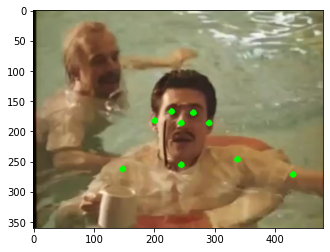

In [96]:
cap = cv2.VideoCapture(r'C:\Users\Alex Zavalny\Desktop\BOLD_public\videos\003\_7oWZq_s_Sk.mp4\0907.mp4')
ret, frame = cap.read()
n=1
for i in range(0, 54, 3):
    if poses[n, 2:][i+2] > 0:
        cv2.circle(frame, (int(poses[n, 2:][i]), int(poses[n, 2:][i+1])), 5, (0, 255, 0),thickness=-1, lineType=cv2.FILLED)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [82]:
train.iloc[5403, :]

video path                                   003/_7oWZq_s_Sk.mp4/0907.mp4
person id                                                               0
framerange start                                                      140
framerange end                                                        188
peace                                                                 0.0
affection                                                             0.0
esteem                                                                0.0
anticipation                                                          0.0
engagement                                                       0.000001
confidence                                                       0.024673
happiness                                                             0.0
pleasure                                                              0.0
excitement                                                            0.0
surprise                              

{
        {0,  "Nose"},
        {1,  "Neck"},
        {2,  "RShoulder"},
        {3,  "RElbow"},
        {4,  "RWrist"},
        {5,  "LShoulder"},
        {6,  "LElbow"},
        {7,  "LWrist"},
        {8,  "RHip"},
        {9,  "RKnee"},
        {10, "RAnkle"},
        {11, "LHip"},
        {12, "LKnee"},
        {13, "LAnkle"},
        {14, "REye"},
        {15, "LEye"},
        {16, "REar"},
        {17, "LEar"},
}

Moving forward:

* Model for COCO Pose Detection
    * OmniPose
    * RSN
    * https://paperswithcode.com/sota/multi-person-pose-estimation-on-coco
* Model for Classification
    * ML Estimators
    * 1D CNN
    * Transformer
    * coordinates + video frame = CNN based DL model
        * VGGNet
        * ResNet
        * 